Mean Absolute Error (Forward Test): 0.0187
R² Score (Forward Test): -1.4151


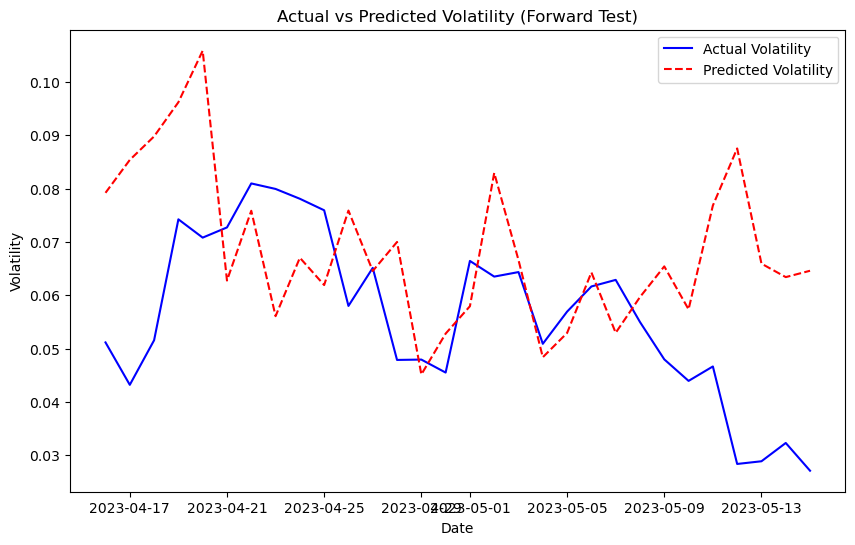

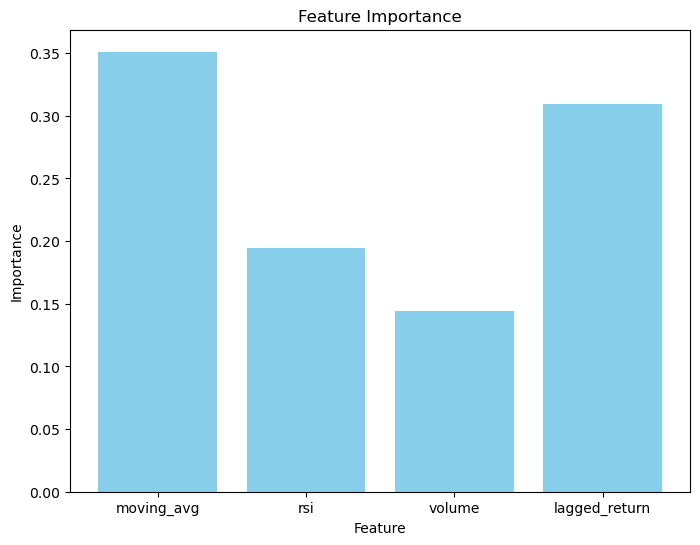

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import requests
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Fetch Bitcoin Historical Data
def fetch_binance_data(symbol, interval, start, end):
    """
    Fetch historical data from Binance API.
    """
    url = "https://api.binance.com/api/v3/klines"
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start,
        'endTime': end,
    }
    response = requests.get(url, params=params)
    data = response.json()
    if "code" in data:  # Check for errors
        print("Error fetching data:", data)
        exit()
    # Create DataFrame
    df = pd.DataFrame(data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
        'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
        'taker_buy_quote_asset_volume', 'ignore'
    ])
    # Clean data
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['close'] = pd.to_numeric(df['close'])
    df['volume'] = pd.to_numeric(df['volume'])
    return df[['timestamp', 'close', 'volume']]

# Fetch data (most recent 1 year + current data for forward testing)
symbol = "BTCUSDT"
interval = "1d"
end_date = int(pd.Timestamp.now().timestamp()) * 1000               # Current timestamp
start_date = int(pd.Timestamp("2022-01-01").timestamp()) * 1000    # Last year

btc_data = fetch_binance_data(symbol, interval, start_date, end_date)

# Step 2: Feature Engineering
btc_data['returns'] = btc_data['close'].pct_change()
btc_data['volatility'] = btc_data['returns'].rolling(window=7).std() * np.sqrt(7)
btc_data['moving_avg'] = btc_data['close'].rolling(window=7).mean()
btc_data['rsi'] = 100 - (100 / (1 + btc_data['returns'].rolling(window=14).mean() /
                                btc_data['returns'].rolling(window=14).std()))
btc_data['lagged_return'] = btc_data['returns'].shift(1)
btc_data.dropna(inplace=True)

# Step 3: Forward-Looking Split
# Use the last month as the "future" for testing
train_data = btc_data.iloc[:-30]
test_data = btc_data.iloc[-30:]

features = ['moving_avg', 'rsi', 'volume', 'lagged_return']
X_train = train_data[features]
y_train = train_data['volatility']
X_test = test_data[features]
y_test = test_data['volatility']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the Model
rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
rf.fit(X_train_scaled, y_train)

# Step 5: Predict and Evaluate
y_pred = rf.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (Forward Test): {mae:.4f}")
print(f"R² Score (Forward Test): {r2:.4f}")

# Step 6: Visualization
# Plot Actual vs Predicted Volatility
plt.figure(figsize=(10, 6))
plt.plot(test_data['timestamp'], y_test, label="Actual Volatility", color="blue")
plt.plot(test_data['timestamp'], y_pred, label="Predicted Volatility", color="red", linestyle="--")
plt.title("Actual vs Predicted Volatility (Forward Test)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

# Feature Importance
importances = rf.feature_importances_
plt.figure(figsize=(8, 6))
plt.bar(features, importances, color='skyblue')
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()
